# Black-Scholes Model 
### Applications *Microsoft - Call Options*

We need the current stock price, exercise price (strike price), time (in years) to expiration date. Those data we can find in Yahoo! finance. 

For stocks Microsoft's call option, we found the following data:

* [MSFT210528C00170000] This is the contract name. 


* Today is 28/04/2021, while the expirated day is 28/05/2021, this mean time to expiration date is 30 days. We have to pass (convert) to years, a year has 365 days, then the time to expiration date (in years) is 30/365.


* Strike price is 170 , current stock price is 254.35 


* Only we need to find two values (variance and risk-free rate) to calculate the value of call To this we will need to install and import a package: **pandas-datareader**


`!pip install pandas-datareader`

`import pandas_datareader as pdr`

In [1]:
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
# for style: this is optional
import qeds
qeds.themes.mpl_style(); 

In [54]:
MSFT = pdr.data.DataReader("MSFT",
                           start='2019-12-18',
                           end= '2021-05-07',
                           data_source='yahoo')
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 349 entries, 2019-12-18 to 2021-05-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       349 non-null    float64
 1   Low        349 non-null    float64
 2   Open       349 non-null    float64
 3   Close      349 non-null    float64
 4   Volume     349 non-null    float64
 5   Adj Close  349 non-null    float64
dtypes: float64(6)
memory usage: 19.1 KB


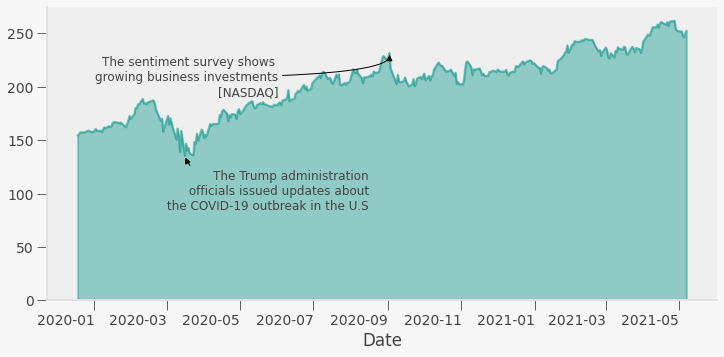

In [56]:
ax = MSFT.Close.plot(kind='area', figsize = (12,6), alpha = 0.4, lw = 2, color = '#029386', rot=0)
ax.grid(False)
text = "The Trump administration\n officials issued updates about\n the COVID-19 outbreak in the U.S"
ax.annotate(
    text,
    xy=(MSFT.Close.idxmin(),MSFT.Close[MSFT.Close.idxmin()]), 
    xycoords="data", xytext=(MSFT.Close.idxmin() + pd.DateOffset(months=5), 
                             MSFT.Close[MSFT.Close.idxmin()] - 50),
    annotation_clip=False,
    horizontalalignment="right",
    arrowprops={
        "arrowstyle": "-|>",
        "connectionstyle": "angle3,angleA=0,angleB=110",
        "color": "black"
    },
    fontsize=12,
)
text = "The sentiment survey shows \ngrowing business investments\n[NASDAQ]"
ax.annotate(
    text,
    xy=(pd.to_datetime('2020-09-02'), MSFT.Close['2020-09-02']), 
    xycoords="data", xytext=(pd.to_datetime('2020-09-02') - pd.DateOffset(months=3)  , 
                             MSFT.Close['2020-09-02'] - 40),
    annotation_clip=False,
    horizontalalignment="right",
    arrowprops={
        "arrowstyle": "-|>",
        "connectionstyle": "angle3,angleA=0,angleB=110",
        "color": "black"
    },
    fontsize=12,
)

fig = ax.get_figure()

We import time series of stock price of Microsoft. 

Period: daily

variable: Adjusted Close

The sample periods (historical) previous month: `'2021/03/28' : '2021/04/28'`

We will calculate the daily returns, then we will calculate annual volatility from daily returns

Annual volatility Formula = $\sigma $ $\sqrt{252}$ 

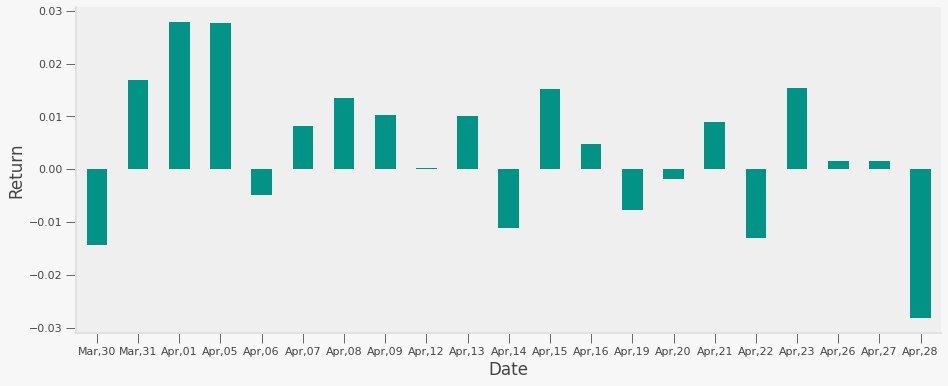

In [5]:
MSFT = MSFT.loc['2021/03/28' : '2021/04/28'].copy()
MSFT_close_daily = MSFT['Adj Close'] 
MSFT_close_daily_return = MSFT_close_daily.pct_change().dropna()
MSFT_close_daily_return.index = MSFT_close_daily_return.index.strftime('%b,%d')
ax = MSFT_close_daily_return.plot(kind = 'bar',figsize=(15.5, 6), rot =0, fontsize = 11, color = '#029386')
ax.grid(False)
ax.set_ylabel('Return')
fig.tight_layout()


Then, we convert to continuous composed

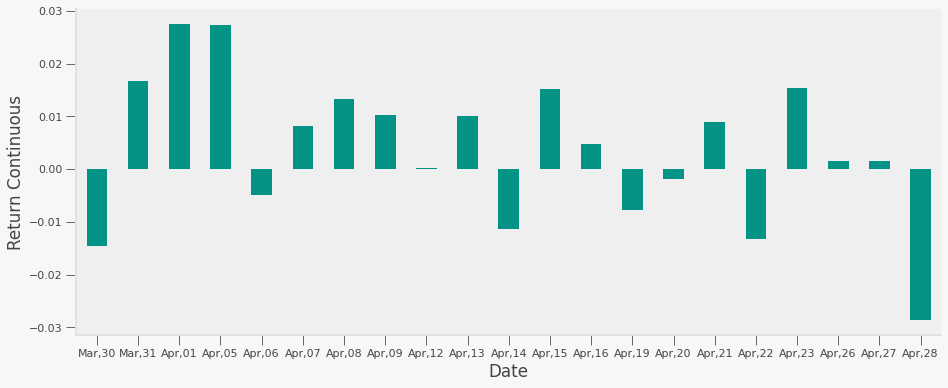

In [6]:
MSFT_close_daily_return_continuous = np.log(1 + MSFT_close_daily_return)
ax = MSFT_close_daily_return_continuous.plot(kind = 'bar',figsize=(15.5, 6), rot =0, fontsize = 11, color = '#029386')
ax.set_ylabel('Return Continuous')
ax.grid(False)
plt.show()

In [7]:
# the standar deviation of continuous return on the stock fer year

annual_volatily = np.sqrt(252)*MSFT_close_daily_return_continuous.std() 
annual_volatily

0.22266724331772045

Now, only we need the risk-free rate.

This is the link where we can find the risk-free rate daily.
https://ycharts.com/indicators/1_year_treasury_rate

The max 1 Year Treasury Rate on 2020 was 1.53%, then we use this rate

The next step is to convert to continuous composition
 
$ r_{continuous} = ln( 1 + r_{1y}) $

In [8]:
r = 0.0153
r_continuous = np.log(1 + r)
r_continuous

0.015184135325040055

We definite the function that calculate the price of call option definite in Black-Scholes Model

In [2]:
from scipy import stats
def call_option_price(S, K, t, r, std):
    """
    call_option_price(S, K, t, r, sdt) computes and returns the exact price of a call option 
    of time to maturity 't' and strike price 'K' given the spot price of the underlying asset 'S', 
    the continuosly compounded short-rate 'r' and variance of the 
    underlying asset var.

    Parameters:
        S (float):     spot price of the underlying asset;
        K (float):     strike price;
        t (float):   time to maturity (in years);
        r (float):     continuously compounded short-rate;
        std (float): sdt of underlying asset;
        
    Returns:
        price (float): call price;

    """
    
    if S == 0: # this is to avoid log(0) issues
        return 0.0
    elif t == 0: # this is to avoid 0/0 issues
        return call_option_payoff(S, K)
    else:
        d1 = (np.log(S / K) + (r + 0.5 * (std**2)) * t) / (std * np.sqrt(t))
        d2 = d1 - std*np.sqrt(t)

        price = S * stats.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * t) * stats.norm.cdf(d2, 0.0, 1.0)

        return price

In [10]:
# to see the parameters

call_option_price?

In [11]:
# the parameters

S = 254.35
K = 170
R =  r_continuous
annual_sdt =  annual_volatily
t = 30/365

In [12]:
call_option_price(S, K, t, R, annual_sdt)

84.56202955594429

But the market price is 91.3, what it is the error?

The inversors may have adjusted the std, incoporating the volatility for the next month.

Let's adjust the std.

How much do we need to adjust for the std?

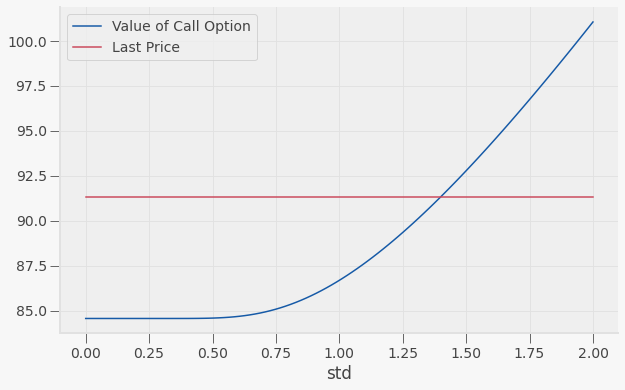

In [13]:
annual_sdt_s = np.linspace(0.00001, 2, 100)
e = []
for _annual_sdt in annual_sdt_s:
    e.append(call_option_price(S, K, t, R, _annual_sdt))
fig, ax = plt.subplots(figsize=(10, 6))    
ax.plot(annual_sdt_s, e, label = 'Value of Call Option')
ax.plot(annual_sdt_s, [91.3]*100, label = 'Last Price')
ax.set_xlabel('std')
ax.legend()
plt.show()

We can see the annual std must be 1.39 (=139%), but the annual std historical was 22%. This mean the expected annual volatility is 117%. Now, this mean expected daily volatility is 7.3%(`=1.17/np.sqrt(252)`) for the next month. 

Other possible answer to error above is the Microsoft's call option have been in the money over last year. This increase its demand, then its price.